# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Pulkit Jain, pj2313

Member 2: Greg Kocher, gk2500

Member 3: Ratheet Pandya, rp2707

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [29]:
DEBUG = False
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda: regularization parameter. Only required in part 2 of the assignment
        """
        np.random.seed(1)
        
        self.parameters = {
            'layerDimensions' : layer_dimensions
        }
        self.num_layers = len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda = reg_lambda
        
        self.iterations_finished = 0
        self.weights = []
        self.biases = []
        
        #FOr debugging
        self.training_accuracies = []
        self.validation_accuracies = []
        self.loss = []
        self.weights_means = []
        self.dW_means = []
        self.weights_sds = []
        self.dW_sds = []        
        
                
        """
        other ideas for increased performance:
        - TA's suggested batchnorm layers
        
        Some that seem easy:
        - decaying learning rate (function of iteration number)
        - random crops/reflections[left-right only]/distortions of input data
        
        - #self.reg_p_norm = 2 #If doing Lp norm regularization
        - other activation functions [ELU]
        """
        
        # init parameters
        
        
    def visualizeWeightsAndGradients(self,gradients):
        """
        Visualization tool for debugging
        """
        
        N = len(self.weights)
        r = int(np.ceil(np.sqrt(N)))
        
        fig=plt.figure()
        plt.title('Weights')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(self.weights[i].flatten(),bins=50)
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten(),bins=50)
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()        
        
        
        #Just make plots of means / sds since easier to see than these histograms
        """
        fig=plt.figure()
        plt.title('Weights')
        clist = ['r','g','b','k','c','m']
        for i in range(N):
            fig.plot(self.weights_means[i],,marker='o',color=clist[i],label='Loss')
            print('Weights', i, 'Mean', self.weights[i].flatten().mean(), 'SD', self.weights[i].flatten().std())
        plt.show()
        
        fig=plt.figure()
        plt.title('dW')
        for i in range(N):
            fig.add_subplot(r,r,i+1)
            plt.hist(gradients['dW'][i].flatten())
            print('dW', i, 'Mean', gradients['dW'][i].flatten().mean(), 'SD', gradients['dW'][i].flatten().std())
        plt.show()      
        """
        
        plt.figure()
        plt.title('Loss vs Iteration (x10)')
        plt.plot(self.loss,marker='o',color='b',label='Loss')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        plt.figure()
        plt.title('Accuracy vs Iteration (x10)')
        plt.plot(self.training_accuracies,marker='o',color='g',label='Train')
        plt.plot(self.validation_accuracies,marker='o',color='r',label='Validation')
        plt.legend(numpoints=1)
        #self.iterations_finished
        plt.show()    
        
        
        
        
    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        Z = np.matmul(W, A) + b
        return Z
        

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return self.relu(A)


    def relu(self, X):
        A = np.maximum(0, X)
        return A

            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        rng = np.random.RandomState(123)
        M = rng.binomial(size=A.shape,
                            n=1,
                            p=1-prob)
        A *= M
        return A, M

    def forwardPropagation(self, X):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        A = X
        

        cache = {
            'biases' : [],
            'weights' : [],
            'dropoutMasks' : [],
            'affines' : [],
            'activations' : [A]
        }
        
        #After already done 1 iteration, reuse the weights and biases we learned:
        if self.iterations_finished > 0:
            cache['biases'] = self.biases
            cache['weights'] = self.weights
            #print(len(cache['weights']))
            #print(cache['weights'][0].shape)
            #print(cache['weights'][1].shape)
            #print(cache['weights'][2].shape)
        
        #same for below random initialization of W and b, are they being overwritten?
        
        for layer in range(1,self.num_layers):
            #On 1st training iteration only, randomly initialize weights and biases:
            if self.iterations_finished==0:
                #Try Xavier-Glorot initialization [http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf]:
                SD_glorot = np.sqrt(2. / (self.parameters['layerDimensions'][layer]+self.parameters['layerDimensions'][layer - 1]))
                #Try MSRA initialization [https://arxiv.org/pdf/1502.01852.pdf]:
                SD_MSRA = np.sqrt(2. / self.parameters['layerDimensions'][layer - 1])
                SD = SD_MSRA
                SD = .01
                W = np.random.normal(0., SD, size=(self.parameters['layerDimensions'][layer], self.parameters['layerDimensions'][layer - 1]))
                b = np.zeros(shape=(self.parameters['layerDimensions'][layer], 1))
            else:
                W = cache['weights'][layer-1]
                b = cache['biases'][layer-1]
            Z= self.affineForward(A, W, b)
            
            #So relu not applied to last layer:
            A = self.activationForward(Z) if layer==self.num_layers-1 else Z
            
            if self.drop_prob > 0:
                A, M = self.dropout(A,self.drop_prob)
                cache['dropoutMasks'].append(M)
            cache['affines'].append(Z)
            cache['activations'].append(A)
            
            if self.iterations_finished==0:
                cache['weights'].append(W)
                cache['biases'].append(b)    

        AL = A
        return AL, cache
    
    def costFunction(self, AL, y, cache):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param alpha: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """
        
        epsilon = 10e-5 #10e-9 #Since taking logs of very small numbers is giving infs
        S = y.size
        
        #Get softmax cost per sample:
        #(both numerators and denominators are length S vectors)
        #denominators = np.exp(AL).sum(axis=0)
        #numerators = np.array([np.exp(AL[y[i]-1,i]) for i in range(S)])#-1 is assuming class labels start at 1. If they start at 0, get rid of -1.
        #Actually will end up needing for gradients so just do as below...
        
        #print(AL)
        #print(AL.min())
        #print(AL.max())
        
        #print(np.exp(AL))
        #print(np.exp(AL).min())
        #print(np.exp(AL).max())
        
        
        #Original, no clipping
        softmax_out = np.exp(AL)/(np.exp(AL).sum(axis=0)+epsilon)
        
        #Nan to num cliping:
        #softmax_out = np.nan_to_num(np.exp(AL))/(np.nan_to_num(np.exp(AL).sum(axis=0))+epsilon)
        
        #Manual clipping
        #max_val = 10e3
        #softmax_out = np.exp(AL).clip(0.,max_val)/(np.exp(AL).clip(0.,max_val).sum(axis=0)+epsilon)
        
        #print(softmax_out)
        #print(softmax_out.min())
        #print(softmax_out.max())

        #Now get the cross-entropy / log-loss of this softmax:
        #cost is the average over all samples
        cost = (-1./S)*np.nansum(np.log(softmax_out))#+epsilon)) #Should deal with nans, but for now just use nansum...

        
        #Also get the regularization cost:
        if self.reg_lambda > 0.:
            # add regularization
            #If want to do other Lp norms as easy bonus:
            #in init: self.reg_p_norm = 2#int p for p-norm regularization
            #FOr now just using L2 norm:
            #||W||^2
            reg_cost = self.reg_lambda*np.array([np.sum(i.flatten()**2) for i in cache['weights']]).sum()
            #print(reg_cost)
            #print(cost)
            cost += reg_cost
        
        
        
        # gradient of cost
        #gradient through cross entropy, then sigmoid, turns out to be:
        #for a single trainign example:
        #dAL_i = sigmoid(z_i) - I(class==i);
        #when go over all training batch examples, 
        #take average over axis 1. Is just sigmoid out array, with certain elements -1.
        #Those elements are the ones corresponding to correct class label, for a given
        #training example:
        softmax_out[y,np.arange(S)] -= 1.
        #Sum over axis 1 and then scale by S, i.e. take mean over samples:
        #dAL = softmax_out.mean(axis=1)#actually since using 2D dropout mask,
        #don't do the averaging now. Leave as 2D matrix with axis1 size = S, the number of samples
        dAL = softmax_out
        
        #Since we don't use ReLU on last layer and treat it 
        #manually in this function by feeding it through softmax layer,
        #get rid of last layer activation here since we basically bypass 
        #the gradient calculation for this last layer and do it separately.
        #THen in the layers before this last one, can treat as usual.
        _ = cache['activations'].pop()
        #Same thing for dropout mask, if doing dropout:
        if self.drop_prob > 0.:
            _ = cache['dropoutMasks'].pop()
        
        return cost, dAL

    
    def affineBackward(self, dA_prev, cache, layer):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :layer : since you need to multiply by weights/biases
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        
        #print('layer',layer)
        
        S = cache['activations'][0].shape[1]
        
        #Use the derivative from the later layer
        #["previous" since goign in reverse]:
        #dA_prev
        
        W = cache['weights'][layer-1]
        dA = np.dot(W.T,dA_prev)
        #print(dA.shape)

        #If doing dropout:
        if self.drop_prob > 0.:
            #Sropout not used directly on input layer, even if mask is generated for it.
            if layer > 1:
                dA = self.dropout_backward(dA, cache)
        dA = self.activationBackward(dA, cache, None, activation="relu")
        
        #Repeat dA_prev since have S samples:
        #dW = np.dot(np.repeat(dA_prev.reshape((dA_prev.size,1)),S,axis=1),cache['activations'][-1].T)
        #Since dropout mask, just keep dA_prev in 2D [don't average over samples]
        dW = np.dot(dA_prev,cache['activations'][-1].T)
        #print(dW)
        #print(dW.min(),dW.max())
        #print(dW.shape)#(10,100)

        
        #If regularized, also add in gradients from reg cost:
        if self.reg_lambda > 0:
            dW += self.reg_lambda*W #For now assuming only L2 reg.
        
        #d_output / db = I(if i)
        db = np.ones(cache['biases'][layer-1].shape)
        
        
        #Now that done using the activations, get rid of them 
        #so indexing correct for next iterations:
        cache['activations'].pop()
        #print(len(cache['activations']))
        #print(cache['activations'][0].shape)

        return dA, dW, db

    
    
    def activationBackward(self, dA, cache, layer, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        cached_x = cache['activations'][-1]
        return self.relu_derivative(dA, cached_x)

        
    def relu_derivative(self, dx, cached_x):

        #S = cached_x.shape[1]
        #Repeat dx since have S samples:
        #dx = np.repeat(dx.reshape((dx.size,1)),S,axis=1)
        
        #In positive region, dx=1; in negative region = 0:
        dx = np.ones(cached_x.shape)*dx
        #Mask the negative region to 0.
        dx[cached_x <= 0.] = 0.
        #Could treat the exact ==0. case differently but to precision will never get ==0.
        
        #Average over axis 1 [averaged over samples]
        #dx = dx.mean(axis=1)#No longer do this since dropout mask
        return dx

    
    def dropout_backward(self, dA, cache):
        dA *= cache['dropoutMasks'].pop()
        return dA

    def backPropagation(self, dAL, Y, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {
            'dW' : [],
            'db' : []
         }
        
        
        dA = dAL
        for layer in range(self.num_layers-1):
            dA, dW, db = self.affineBackward(dA,cache,self.num_layers-layer-1)
            gradients['dW'].append(dW) 
            gradients['db'].append(db) 
            
            #Was easier to just put inside affineBackward...
            #if self.drop_prob > 0:
            #    #If not working on the input layer (don't use dropout on it):
            #    if layer < self.num_layers-2 #-2 since: 
            #        self.dropout_backward(dA,cache)
           
        # TODO    
        #if self.reg_lambda > 0:
            # add gradients from L2 regularization to each dW
            #GK: I'm just adding them to dAL in the costfunction so should be ok w/o this here
        gradients['dW'].reverse()
        gradients['db'].reverse() 
        return gradients


    def updateParameters(self, gradients, alpha, cache):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        
        cache: to update the parameters we are learning [weights and biases],
        those values also need to be passed in.
        """
        
        #Weights
        #print(cache['weights'][0])
        #print(gradients['dW'][0].min())
        #print(gradients['dW'][0].max())
        cache['weights'] = [cache['weights'][i]  - alpha*gradients['dW'][i] for i in range(len(cache['weights']))] 
        #print(cache['weights'][0])
        #print(cache['weights'][0].max())
        #print(cache['weights'][0].min())

        #biases
        #print(cache['biases'][0])
        cache['biases'] = [cache['biases'][i]  - alpha*gradients['db'][i] for i in range(len(cache['biases']))] 
        #print(cache['biases'][0])
    
                
    def predict(self, X):
        """
        Make predictions for each sample
        """
        
        AL, _ = self.forwardPropagation(X)
        
        #Get probability per class per sample, then take argmax:
        #Technically don't need to go through softmax calculations, etc. since max here is max after too.
        #SO just get argmax for each sample:
        y_pred = np.argmax(AL,axis=0)

        if DEBUG:
            print(y_pred)
            print(np.bincount(y_pred))
        #y_pred = [100, 200, 300]
        
        return y_pred

    
    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        selector = np.random.choice(np.arange(np.size(y)), batch_size, replace=False)
        return X[:, selector], y[selector]

    def train(self, X, y, iters=1000, alpha=0.0001, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        #Split training data into training and validation set (90/10 split):
        np.random.seed(123456)
        train_inds = np.random.choice(X.shape[1],int(X.shape[1]*.90),replace=False)
        validation_inds = np.setdiff1d(np.arange(X.shape[1]),train_inds)
        X_training = X[:,train_inds]
        y_training = y[train_inds]
        X_validation = X[:,validation_inds]
        y_validation = y[validation_inds]
        #print(X_training.shape, y_training.shape, X_validation.shape, y_validation.shape)
        
        
        #Do training iterations
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X_training, y_training, batch_size)
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch)

            # compute loss
            cost, dAL = self.costFunction(AL, y_batch, cache)
            #print('cost',cost)
            
            # compute gradients
            gradients = self.backPropagation(dAL, y_batch, cache)
            #print('gradients',gradients,len(gradients['dW']),gradients['dW'][0].shape)

            # update weights and biases based on gradient
            #print('alpha',alpha)
            self.updateParameters(gradients, alpha, cache) #will update weights + biases in place

            
            #Store the weights and biases that were just updated: 
            self.weights = cache['weights']
            self.biases = cache['biases']
            #print(len(self.weights))
            #print(len(self.biases))
            #print(self.weights[0].shape)
            #print(self.biases[0].shape)
            
            
            #Iteration counter
            self.iterations_finished += 1
            
            
            if i % print_every == 0:
                #Training set accruacy:
                y_batch_predicted = self.predict(X_batch)
                train_accuracy = (y_batch_predicted==y_batch).sum()/np.float(batch_size)
                #Validation set accuracy:
                y_validation_predicted = self.predict(X_validation)
                validation_accuracy = (y_validation_predicted==y_validation).sum()/np.float(y_validation.size)
                print('iteration: {}, cost: {}, train accuracy: {}, validation accuracy: {}'.format(
                    i, cost, train_accuracy, validation_accuracy))
                
                self.training_accuracies += [train_accuracy]
                self.validation_accuracies += [validation_accuracy]
                self.loss += [cost]
          
            #For debugging, look at weights and gradients on weights
            if DEBUG and i % 100 == 0:
                self.visualizeWeightsAndGradients(gradients)


In [4]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [5]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:#[:20000]:#!!!!!!! changed for memory issues, but change this back to "files:"
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [6]:
# Load the data
data_root_path = '/Users/ratheet/coms4995-deeplearning/HW1/git/cifar10-hw1/'
data_root_path = '.././cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


## Part 1

#### Simple fully-connected deep neural network

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[  0 100]
[1 1 1 ..., 1 1 1]
[   6 4979    3    2    0    2    0    0    0    8]
cost: 23.02655595549022, train accuracy: 0.14, validation accuracy: 0.1022
1


Weights 0 Mean 5.52517142224e-06 SD 0.00999916436814
Weights 1 Mean -0.000111099876368 SD 0.0099360791709


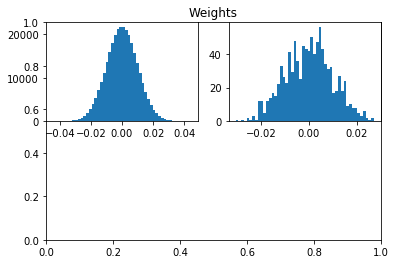

dW 0 Mean 0.00156643595638 SD 0.0361852038661
dW 1 Mean -1.32095215922e-06 SD 0.881865463655


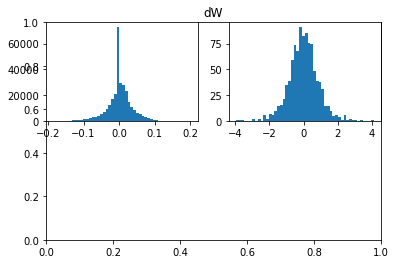

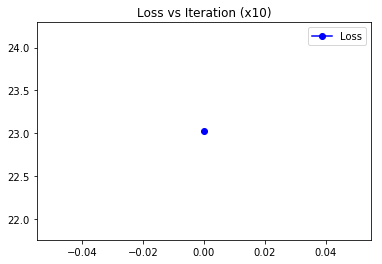

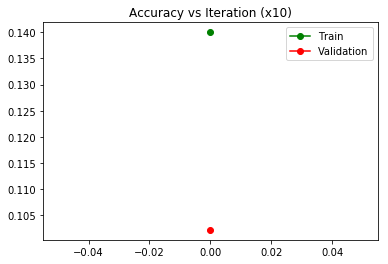

[0 0 0 9 9 9 7 9 0 0 9 0 0 9 0 9 0 0 0 9 0 9 0 0 0 9 9 0 0 0 0 0 0 0 9 0 0
 9 9 0 0 0 0 0 0 0 0 9 0 0 0 9 0 0 0 9 0 0 0 9 0 0 0 0 0 9 0 9 0 0 0 9 0 9
 0 0 0 9 9 0 0 0 0 9 0 0 9 9 9 9 9 9 0 0 0 0 0 0 9 0]
[67  0  0  0  0  0  0  1  0 32]
[0 0 0 ..., 9 0 0]
[3354    0   20    0    0    0    0    4    3 1619]
cost: 23.040144013331105, train accuracy: 0.17, validation accuracy: 0.1468
11


[0 8 5 5 5 5 5 0 5 8 5 5 5 0 8 8 0 5 5 5 5 5 5 5 8 5 5 5 9 5 8 5 5 5 8 0 5
 0 8 8 8 5 5 8 5 5 5 5 5 5 5 5 8 5 5 5 5 5 5 8 5 5 5 8 8 5 5 5 5 8 5 0 5 0
 8 5 5 8 5 8 5 5 5 8 8 5 5 5 5 0 9 5 8 5 5 9 5 5 5 8]
[ 9  0  0  0  0 65  0  0 23  3]
[5 8 5 ..., 5 5 5]
[ 473    0    9    0    1 2926    0    7 1213  371]
cost: 23.03611499881412, train accuracy: 0.24, validation accuracy: 0.1938
21


[8 7 8 8 5 8 8 8 8 2 8 8 8 8 8 8 8 8 5 8 8 8 8 2 8 8 8 5 5 8 8 8 8 2 8 8 8
 8 8 8 5 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 2 8 8 8
 8 8 8 8 8 8 2 8 8 2 8 2 5 8 8 8 8 8 8 8 8 8 8 8 2 8]
[ 0  0 10  0  0  6  0

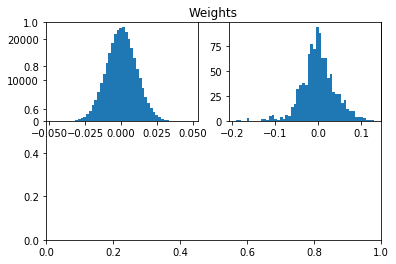

dW 0 Mean 0.0569991806817 SD 0.371418717864
dW 1 Mean -1.02993703233e-05 SD 3.66708589946


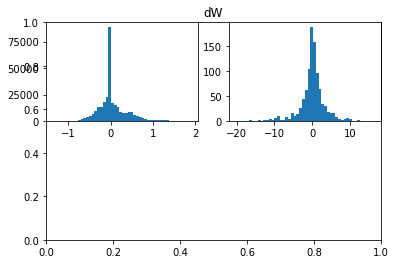

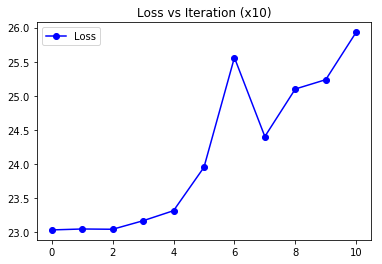

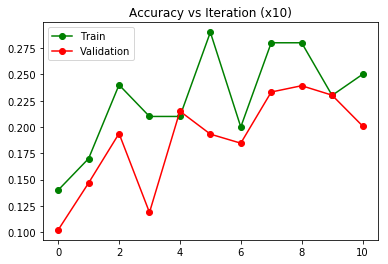

[5 8 8 1 9 8 5 1 1 0 5 8 1 5 9 8 5 1 6 6 8 8 7 5 8 8 8 9 1 5 6 5 1 1 8 6 1
 1 1 1 5 8 1 5 5 6 1 0 8 5 9 5 5 1 9 0 8 1 1 5 1 5 6 8 1 8 1 9 1 1 6 5 5 8
 8 5 5 1 8 8 8 1 1 5 5 5 8 6 5 1 5 5 6 1 8 1 8 6 5 5]
[ 3 28  0  0  0 28 10  1 24  6]
[5 8 1 ..., 1 5 5]
[  34 1248    0   44    7 1641  429   27 1123  447]
cost: 26.836221851382017, train accuracy: 0.27, validation accuracy: 0.2292
111


[9 0 6 1 5 8 5 1 6 1 1 7 6 7 1 6 5 6 7 5 4 6 8 9 6 1 6 6 7 8 9 6 6 5 9 6 9
 7 9 6 6 1 0 6 6 1 7 8 6 5 8 7 9 9 9 6 6 9 6 6 2 1 1 1 9 1 0 0 6 6 1 6 6 6
 7 8 8 6 2 9 0 8 6 7 8 1 9 7 7 1 0 6 2 3 7 6 6 5 7 6]
[ 6 15  3  1  1  7 32 13  9 13]
[6 1 1 ..., 1 7 6]
[ 349  723  119   37   70  237 1185 1147  574  559]
cost: 26.0131744673115, train accuracy: 0.3, validation accuracy: 0.2702
121


[5 7 1 5 9 5 7 5 6 0 6 5 5 2 5 5 3 5 6 5 9 6 6 9 0 5 1 7 9 8 5 9 5 7 5 6 5
 8 1 9 5 2 0 5 5 0 9 5 9 5 5 5 2 5 5 5 5 1 1 8 5 1 1 7 5 5 1 2 5 5 1 5 5 5
 1 5 5 7 6 0 0 6 0 5 6 1 5 0 7 5 5 5 1 5 5 7 5 1 5 5]
[ 8 13  4  1  0 46  9

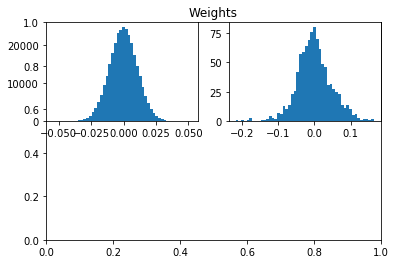

dW 0 Mean 0.0324356620548 SD 0.244112611462
dW 1 Mean 1.17148863887e-05 SD 8.96523754648


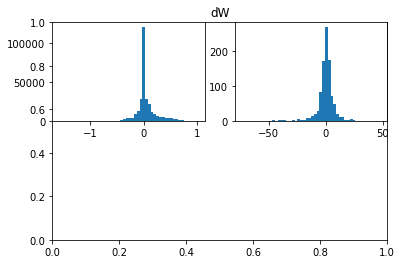

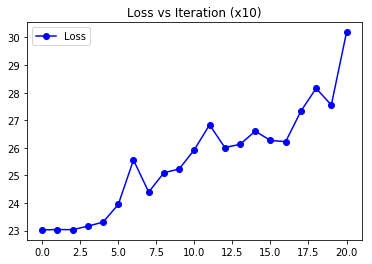

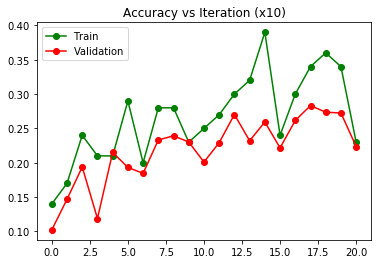

[2 6 1 2 7 2 2 9 2 6 7 0 7 2 8 9 0 8 2 0 8 5 1 1 6 2 5 1 8 7 5 2 1 7 1 5 2
 1 1 8 2 0 2 2 1 2 1 2 0 1 0 6 0 8 0 7 7 7 2 7 1 2 2 2 7 6 0 1 6 5 9 7 2 1
 0 0 5 0 2 6 6 8 2 6 0 2 1 6 1 1 2 8 5 7 8 1 2 7 2 0]
[14 18 26  0  0  7 10 13  9  3]
[5 1 2 ..., 1 2 2]
[ 415  992 1377    5    0  197  414  566  898  136]
cost: 27.44767813810378, train accuracy: 0.31, validation accuracy: 0.288
211


[2 7 0 7 7 9 7 2 5 7 7 7 7 7 1 0 2 1 7 7 0 0 7 7 0 7 7 4 0 1 5 8 7 7 0 7 2
 0 5 7 7 0 7 4 0 7 2 0 2 2 0 7 2 7 4 7 5 6 0 1 7 7 8 5 7 0 1 7 7 7 4 8 7 7
 7 0 7 7 6 6 7 4 7 7 7 7 0 7 7 7 7 7 7 2 7 0 6 0 7 8]
[18  5  9  0  5  5  4 49  4  1]
[5 2 2 ..., 5 7 2]
[ 707  296  668    5  281  352  145 2267  150  129]
cost: 27.50969359702879, train accuracy: 0.28, validation accuracy: 0.229
221


[0 3 5 6 0 5 3 1 9 4 0 5 9 9 4 5 6 9 0 3 4 9 3 7 5 9 4 9 4 1 9 8 0 4 9 5 9
 0 9 7 9 9 4 4 7 0 9 8 4 9 9 9 0 9 1 5 0 7 9 0 6 4 5 9 7 7 0 9 4 7 0 7 0 7
 6 4 9 6 9 9 5 5 9 9 7 5 9 4 2 3 9 5 4 4 3 6 0 9 9 9]
[14  3  1  6 15 12  6 

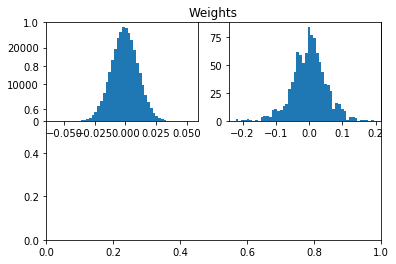

dW 0 Mean -0.029536867648 SD 0.0985624225337
dW 1 Mean 3.26906504624e-05 SD 14.9178238896


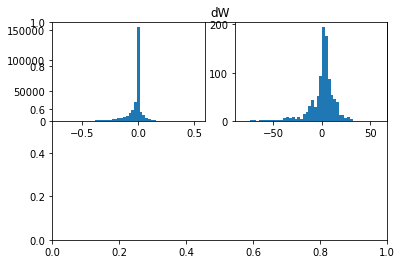

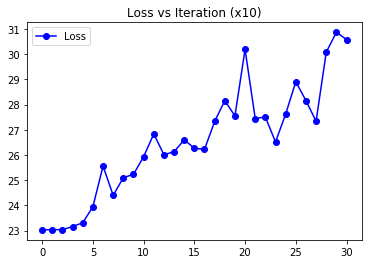

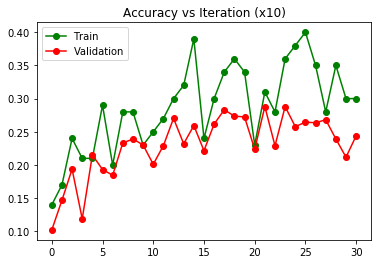

[1 5 2 1 5 5 0 5 2 5 2 1 0 0 0 5 1 5 1 2 2 1 1 0 5 5 1 1 5 5 5 0 2 5 0 5 1
 0 5 1 0 0 5 1 1 2 1 1 1 5 2 2 5 2 2 1 2 5 5 2 5 1 5 0 5 1 2 1 1 0 1 5 2 0
 5 2 5 1 5 5 5 5 2 5 5 5 2 5 5 5 5 1 5 1 2 2 5 5 0 1]
[14 26 20  0  0 40]
[5 1 5 ..., 5 5 5]
[ 540 1172  768    0    2 2461    0    0   57]
cost: 33.337902271525884, train accuracy: 0.3, validation accuracy: 0.2102
311


[6 4 6 5 5 3 8 9 8 5 5 4 6 4 5 6 4 1 4 6 5 4 5 8 5 5 8 9 6 8 6 1 5 5 1 8 4
 8 5 5 8 4 0 1 8 6 6 4 6 5 0 8 5 6 6 6 5 3 6 8 4 8 1 5 8 9 8 9 5 8 5 6 8 5
 6 6 8 8 6 5 6 8 8 1 6 5 6 4 5 5 0 6 8 6 6 5 8 8 8 6]
[ 3  6  0  2 11 25 25  0 24  4]
[5 8 5 ..., 5 5 5]
[ 222  477    0  144  813 1247  823    8 1101  165]
cost: 27.091621489345, train accuracy: 0.39, validation accuracy: 0.285
321


[0 0 5 6 0 6 0 6 9 5 0 6 0 6 6 6 9 8 0 0 9 6 0 5 0 0 7 5 7 7 0 7 6 5 0 8 6
 7 6 7 5 6 7 6 6 7 9 0 7 6 0 0 6 0 5 0 7 6 0 6 6 6 7 6 5 6 0 7 0 0 0 0 0 0
 6 6 0 5 6 5 6 6 0 5 6 0 6 0 7 0 7 6 5 0 3 0 6 6 6 6]
[33  0  0  1  0 12 34 14  2  4]
[6 0 6 .

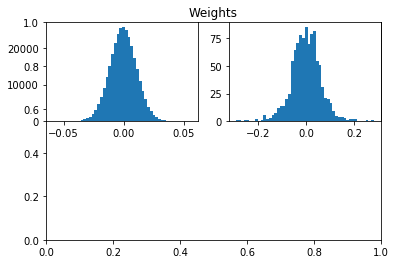

dW 0 Mean -0.0389319930427 SD 0.120292174797
dW 1 Mean 3.56058381458e-05 SD 12.2335591517


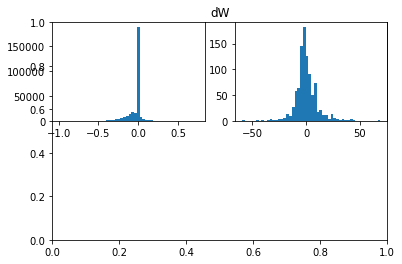

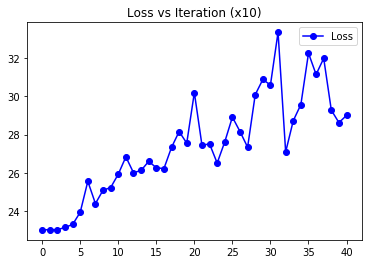

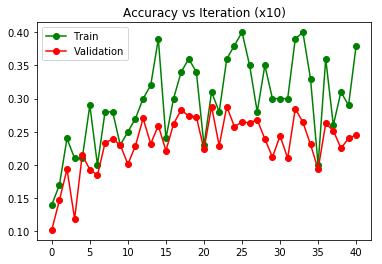

[6 9 6 6 6 6 8 8 6 6 6 9 8 6 6 6 9 0 6 6 6 8 0 6 9 6 9 8 6 9 9 7 6 8 7 6 9
 7 0 6 6 6 7 6 6 8 6 6 8 5 6 9 9 6 7 6 6 9 6 8 6 5 6 6 6 6 8 6 6 7 6 8 6 8
 0 0 6 6 6 9 6 6 6 6 6 6 7 6 6 6 6 5 9 6 6 5 6 8 0 6]
[ 6  0  0  0  0  4 57  7 13 13]
[6 8 6 ..., 6 6 6]
[ 336   59    0    0    0  164 2495  457  585  904]
cost: 30.876524979937795, train accuracy: 0.33, validation accuracy: 0.2712
411


[2 0 2 4 2 0 2 0 0 1 0 1 2 0 2 1 1 2 4 0 0 4 4 1 0 4 1 2 0 2 1 2 1 1 2 2 0
 2 2 4 0 0 2 2 2 2 4 4 2 2 8 2 1 4 0 3 4 0 2 4 1 0 1 2 2 2 2 2 1 2 2 4 1 1
 1 2 2 0 0 1 0 2 2 2 2 2 2 1 1 2 4 1 2 1 1 2 1 2 2 0]
[20 23 42  1 13  0  0  0  1]
[2 1 2 ..., 1 2 2]
[ 960 1239 1971  129  570    2   90    0   39]
cost: 30.76828254413391, train accuracy: 0.23, validation accuracy: 0.2244
421


[7 8 5 5 7 1 7 7 1 1 1 3 1 7 7 7 7 3 3 7 5 7 7 7 1 7 7 5 5 5 8 1 1 1 1 7 5
 1 5 1 5 5 7 7 7 7 7 7 1 5 1 5 1 1 7 7 1 7 7 7 1 5 7 7 7 1 5 1 1 7 7 7 1 5
 5 1 8 1 1 7 5 1 7 7 7 5 7 7 5 3 7 5 7 8 5 1 7 1 5 7]
[ 0 28  0  4  0 22  0 42  4

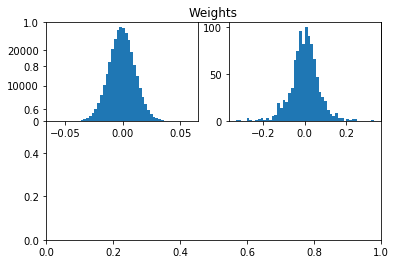

dW 0 Mean 0.0298664406647 SD 0.15546308968
dW 1 Mean 3.98020116934e-05 SD 15.5898503898


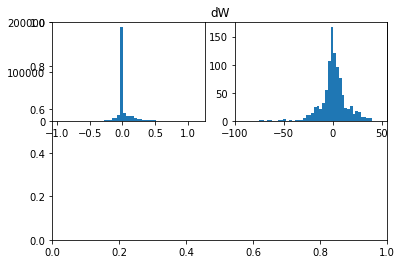

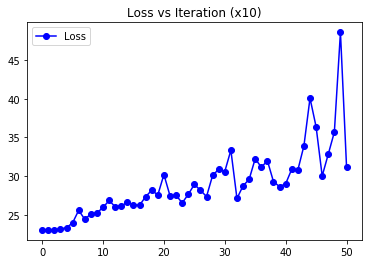

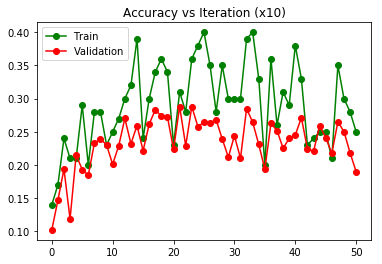

[6 2 2 2 6 6 2 2 9 9 2 6 9 2 2 2 2 2 2 9 6 2 2 9 6 9 9 9 6 0 2 2 9 6 2 9 2
 2 6 9 2 6 2 2 2 6 9 9 6 2 2 9 1 2 9 2 2 6 6 2 2 9 2 6 2 2 2 9 9 6 2 2 6 2
 2 2 2 9 2 2 2 2 6 2 6 2 2 9 2 6 0 6 2 2 6 6 6 2 6 2]
[ 2  1 52  0  0  0 25  0  0 20]
[6 2 2 ..., 2 2 2]
[  93    7 2465    0    0    0 1363    0    0 1072]
cost: 47.76437445395783, train accuracy: 0.23, validation accuracy: 0.2044
511


[6 5 5 5 5 5 5 5 1 5 6 6 6 5 1 5 1 6 5 5 1 5 6 5 5 5 1 1 1 5 5 1 5 5 6 5 1
 5 5 6 5 5 5 5 6 6 5 5 5 1 1 6 5 5 1 6 6 5 6 6 1 1 1 6 5 1 5 5 5 6 6 5 6 5
 5 1 5 5 6 5 6 5 6 1 5 5 5 5 6 6 5 5 5 6 5 1 5 5 6 6]
[ 0 19  0  0  0 54 27]
[5 5 5 ..., 5 5 5]
[   0 1106   23    0    0 2277 1450    0    2  142]
cost: 41.303699714381544, train accuracy: 0.33, validation accuracy: 0.2002
521


[4 4 4 4 8 4 4 4 4 4 4 4 9 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 8 4 4 8 4 4 8 4 4
 4 4 4 4 8 4 9 4 4 4 4 4 4 4 4 1 4 4 4 4 9 4 4 4 4 4 8 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 9 8 4 4 4 4 8 1 4 9]
[ 0  2  0  1 84  0  0  0  8 

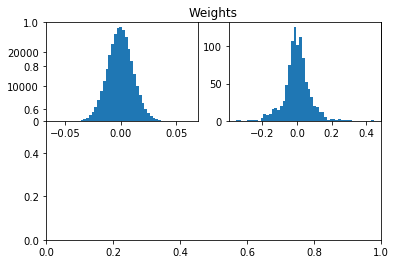

dW 0 Mean 0.038545421212 SD 0.332313352139
dW 1 Mean 2.44498969e-05 SD 18.8742321195


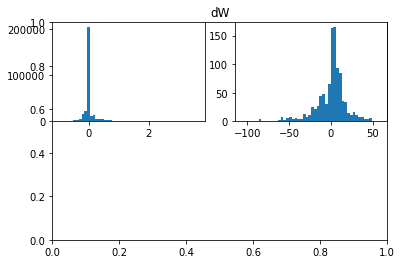

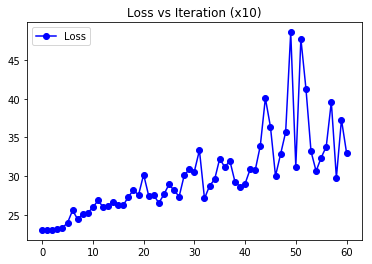

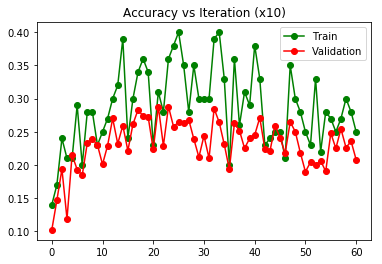

[0 0 0 0 6 0 0 0 2 0 0 0 0 2 2 0 0 2 0 0 2 0 0 0 0 0 0 6 6 1 1 2 0 0 0 2 0
 2 0 0 1 2 1 6 0 1 2 2 2 0 0 0 2 8 0 2 8 2 2 0 2 2 1 2 2 6 0 0 0 2 0 2 2 0
 2 2 2 0 2 2 0 0 2 0 0 2 0 2 0 2 2 2 6 6 2 2 0 0 2 0]
[48  6 37  0  0  0  7  0  2]
[2 0 2 ..., 0 0 2]
[1930  636 2115    0    0    6  243    0   70]
cost: 39.118322004490764, train accuracy: 0.25, validation accuracy: 0.2072
611


[2 1 2 2 2 1 6 2 6 2 2 2 6 2 8 2 1 1 8 2 5 6 8 2 1 2 8 8 1 2 0 1 2 1 8 2 8
 2 1 2 1 2 8 6 8 8 1 8 2 2 2 1 8 6 1 2 2 8 8 5 2 8 2 8 2 1 0 1 8 6 5 5 2 1
 1 2 1 8 5 2 2 6 2 8 8 1 8 8 1 8 6 2 1 1 2 2 8 1 1 6]
[ 2 24 35  0  0  5 10  0 24]
[6 1 2 ..., 1 1 2]
[  68 1566 1553    0    0  138  517    0 1132   26]
cost: 40.63418967884411, train accuracy: 0.27, validation accuracy: 0.2518
621


[6 5 0 5 4 6 5 0 4 0 8 4 4 4 5 4 8 4 0 4 5 0 0 5 0 8 6 5 0 6 4 5 4 5 8 6 6
 5 5 6 0 8 0 8 4 6 0 8 6 8 5 5 6 4 7 5 5 4 0 0 6 6 4 8 6 8 8 0 8 6 5 4 5 7
 0 8 4 4 4 0 6 5 8 8 5 4 5 0 5 4 0 8 8 1 5 5 7 0 6 8]
[19  1  0  0 20 23 16  3 18]
[

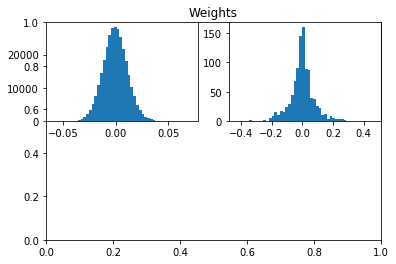

dW 0 Mean -0.0146886524986 SD 0.0790945674871
dW 1 Mean 4.86357166149e-05 SD 11.4508566174


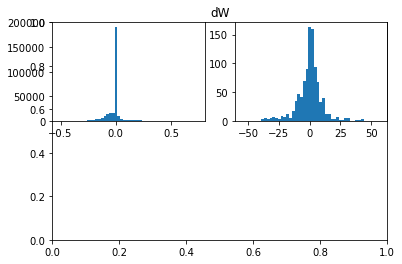

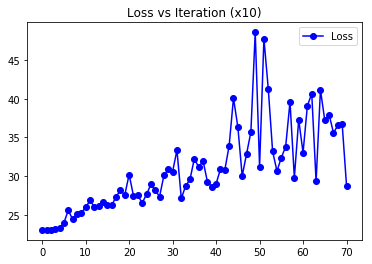

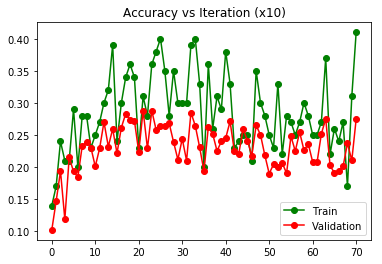

[6 8 6 6 9 9 0 4 6 0 6 6 9 9 0 8 9 0 6 6 6 0 6 9 6 9 6 6 6 6 9 9 7 6 0 9 9
 6 6 8 6 5 6 9 9 6 7 7 0 0 6 0 0 9 0 8 8 6 0 9 9 9 6 0 6 6 9 6 6 6 9 6 0 9
 9 9 6 9 9 6 6 8 9 6 5 9 6 9 6 9 6 0 0 6 9 6 9 9 9 6]
[16  0  0  0  1  2 40  3  6 32]
[6 8 6 ..., 6 6 6]
[ 644    6    0    0   26   81 2174  100  206 1763]
cost: 35.55823711251821, train accuracy: 0.32, validation accuracy: 0.2404
711


[0 0 0 0 5 5 6 5 0 0 0 0 0 0 0 6 6 5 0 6 0 5 0 6 5 5 5 5 6 5 0 5 6 6 5 0 6
 0 0 0 6 0 0 6 5 6 6 0 0 5 1 0 6 6 0 0 6 5 0 5 0 5 5 5 0 0 5 5 6 0 5 6 6 5
 5 5 5 0 0 6 5 5 0 0 0 0 5 0 0 5 0 0 6 5 0 5 6 0 0 5]
[44  1  0  0  0 33 22]
[5 5 6 ..., 5 5 5]
[1977   31    0    0    0 1440 1552]
cost: 33.83104863318222, train accuracy: 0.28, validation accuracy: 0.207
721


[7 8 8 8 8 8 7 8 7 8 8 7 5 8 8 8 8 8 8 7 8 8 8 7 8 7 8 8 8 8 8 8 8 7 8 8 8
 8 8 8 8 8 7 8 8 8 8 8 7 8 8 8 7 0 7 7 8 8 8 8 8 8 8 8 7 8 8 8 8 7 8 8 8 8
 7 3 8 7 8 8 8 8 7 8 7 8 7 8 8 8 7 8 7 8 8 7 7 8 7 7]
[ 1  0  0  1  0  1  0 26 71]
[7 8 8 ..., 8 8 

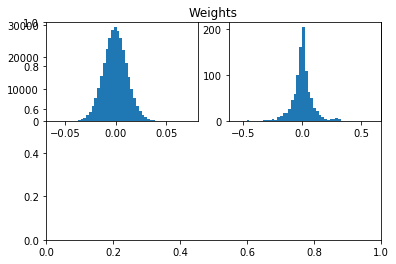

dW 0 Mean -0.000264090477299 SD 0.255450988161
dW 1 Mean 1.17202253409e-06 SD 25.8378796137


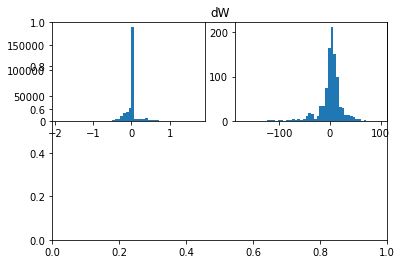

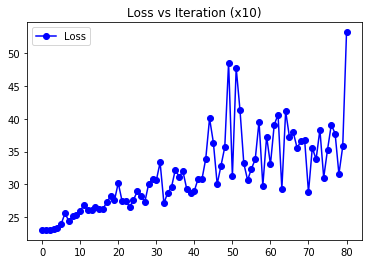

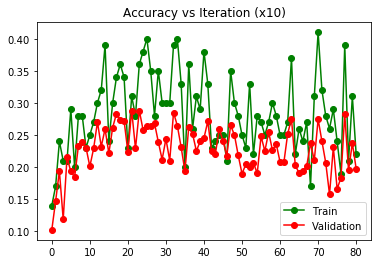

[2 2 2 9 1 2 2 9 8 8 8 2 1 2 2 2 8 2 8 2 2 8 8 9 9 8 2 2 2 2 2 2 2 1 8 2 2
 2 2 2 2 8 2 2 1 2 2 2 8 2 2 2 2 2 1 2 2 2 2 8 8 8 2 2 2 8 2 1 2 2 2 2 2 8
 2 2 9 2 2 2 1 9 8 2 8 8 8 8 8 2 2 8 2 2 8 2 2 2 1 2]
[ 0  8 62  0  0  0  0  0 24  6]
[2 8 2 ..., 2 2 2]
[   0  263 3378    0    9    0   21    0  930  399]
cost: 51.5680964158094, train accuracy: 0.21, validation accuracy: 0.21
811


[3 3 3 3 3 8 6 8 8 3 8 3 8 3 6 6 3 2 3 6 6 3 3 8 3 8 8 8 3 8 8 3 6 3 8 8 8
 8 6 3 8 8 3 2 3 6 6 0 3 3 6 8 8 8 8 3 3 3 6 3 6 3 3 8 8 3 3 3 3 8 2 8 3 6
 8 3 8 6 3 8 3 3 8 8 6 0 6 8 3 8 8 3 3 8 8 8 3 3 8 6]
[ 2  0  3 41  0  0 17  0 37]
[3 8 3 ..., 3 3 6]
[ 138   10   86 1995    1    0  953    0 1817]
cost: 41.290690273825106, train accuracy: 0.22, validation accuracy: 0.2122
821


[1 6 1 8 3 1 6 1 1 1 8 6 1 6 6 1 1 6 1 1 6 1 1 1 1 1 8 1 1 6 6 1 6 1 9 6 1
 6 1 6 1 9 1 8 9 6 1 1 1 6 1 1 1 1 6 8 6 1 1 6 1 6 6 6 6 1 1 6 8 8 1 1 6 6
 6 1 1 8 3 6 8 6 9 1 1 9 6 1 6 6 1 1 8 9 6 1 1 1 1 1]
[ 0 50  0  2  0  0 32  0 10  6

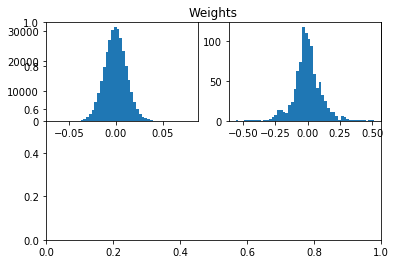

dW 0 Mean 0.00447943078836 SD 0.219970132333
dW 1 Mean 1.51266283501e-06 SD 50.1418062109


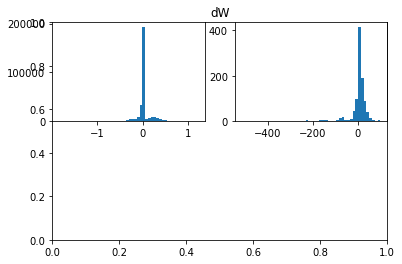

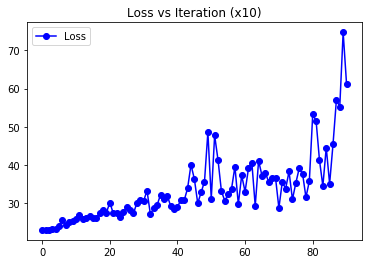

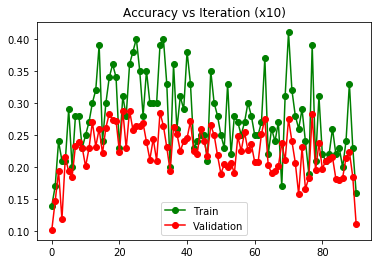

[2 2 3 8 2 3 2 8 2 2 2 8 2 2 2 8 7 2 2 8 2 2 2 8 2 2 2 3 2 2 2 8 2 3 2 8 7
 2 3 2 2 3 2 2 2 2 3 6 2 2 3 7 3 2 2 2 2 2 2 2 2 2 2 8 7 3 2 8 2 2 2 2 2 2
 2 8 2 2 8 2 2 2 8 2 2 3 8 8 2 8 2 2 2 3 2 2 8 3 2 8]
[ 0  0 64 13  0  0  1  4 18]
[3 2 2 ..., 3 2 2]
[   0   41 2768  871    0    0  151  360  809]
cost: 95.95353093284274, train accuracy: 0.21, validation accuracy: 0.1912
911


[8 6 8 8 6 6 6 3 8 3 8 8 6 6 8 8 3 3 6 8 8 8 6 8 8 8 3 8 8 6 3 3 8 6 8 6 8
 8 8 8 6 6 8 6 6 6 3 6 6 3 8 3 6 3 6 6 6 3 8 6 8 3 8 6 6 6 3 3 8 8 6 3 3 3
 3 3 6 8 8 8 3 5 5 6 8 6 6 8 3 8 8 8 8 8 5 6 8 8 6 3]
[ 0  0  0 23  0  3 33  0 41]
[3 8 3 ..., 3 3 3]
[   7    0    0 1312    0  323 1424    0 1934]
cost: 115.26888134769054, train accuracy: 0.17, validation accuracy: 0.1908
921


[0 5 0 5 5 0 0 5 5 0 0 5 0 4 0 5 5 0 5 4 0 5 0 5 5 0 0 5 0 0 5 0 0 0 0 0 5
 0 0 0 0 0 0 0 5 5 5 0 0 5 5 0 0 0 5 5 0 0 0 0 5 0 0 0 0 0 5 5 0 5 5 4 5 0
 5 0 5 5 0 5 4 0 0 5 0 5 5 0 0 0 0 5 5 5 0 0 5 5 0 0]
[56  0  0  0  4 40]
[5 5 5 ..., 5 5

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:248: RuntimeWarning: overflow encountered in exp
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:248: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:263: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in maximum
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:382: RuntimeWarning: invalid value encountered in less_equal


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[100]
[0 0 0 ..., 0 0 0]
[5000]
cost: -0.0, train accuracy: 0.09, validation accuracy: 0.101
971


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[100]
[0 0 0 ..., 0 0 0]
[5000]
cost: -0.0, train accuracy: 0.08, validation accuracy: 0.101
981


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[100]
[0 0 0 ..., 0 0 0]
[5000]
cost: -0.0, train accuracy: 0.11, validation accuracy: 0.101
991


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

ValueError: max must be larger than min in range parameter.

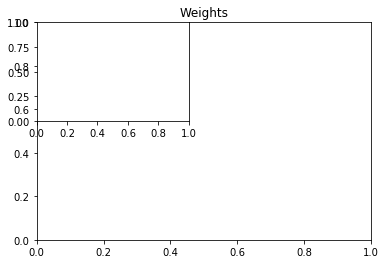

In [30]:
layer_dimensions = [X_train.shape[0], 100, 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, iters=2000, alpha=0.001, batch_size=100, print_every=10)

In [498]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

[0 0 0 ..., 0 0 0]
[10000]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in maximum


In [499]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

(10000,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
layer_dimensions = [X_train.shape[0], 1000, 100, 10]  # including the input and output layers
NN2 = NeuralNetwork(layer_dimensions, drop_prob=.5, reg_lambda=.1)
X_train2 = X_train[:,:500]
y_train2 = y_train[:500]
NN2.train(X_train2, y_train2, iters=50000, alpha=0.00001, batch_size=100, print_every=10)#alpha=0.00001

In [502]:
y_predicted2 = NN2.predict(X_test)
save_predictions('ans2-uni',y_predicted)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in maximum


[0 0 0 ..., 0 0 0]
[10000]
